# Lesson 3

In [1]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math

import matplotlib.pyplot as plt

## 00:00:00 - Examples of students study materials

* [AWS fastai GPU Image Setup](https://github.com/reshamas/fastai_deeplearn_part1/blob/master/tools/aws_ami_gpu_setup.md).
* [tmux on AWS](https://github.com/reshamas/fastai_deeplearn_part1/blob/master/tools/tmux.md).
* [Case Study: A world class image classifier for dogs and cats (err.., anything)](https://medium.com/@apiltamang/case-study-a-world-class-image-classifier-for-dogs-and-cats-err-anything-9cf39ee4690e)
  * Summary of last lessons.
* [Estimating an Optimal Learning Rate For a Deep Neural Network](https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0)
* [A practitioner's guide to PyTorch](https://towardsdatascience.com/a-practitioners-guide-to-pytorch-1d0f6a238040)
* [Visualizing Learning rate vs Batch size](https://miguel-data-sc.github.io/2017-11-05-first/)
* [Do smoother areas of the error surface lead to better generalization?](https://medium.com/@radekosmulski/do-smoother-areas-of-the-error-surface-lead-to-better-generalization-b5f93b9edf5b)
* [Convolutional Neural Network in 5 minutes](https://hackernoon.com/convolutional-neural-network-in-5-minutes-8f867eb9ca39)
* [Decoding the ResNet architecture](http://teleported.in/posts/decoding-resnet-architecture/)

* [Fast.AI beginner forum](http://forums.fast.ai/c/part1v2-beg).

## 00:06:30 - Recap of lessons so far

* So far looked at image classification and CNNs as a practitioner.
* Going to look at CNN theory today.
* Then, intro to CNN for structured data.
* Language RNN intro.
* Collaborative filtering intro.
* Then a deep dive into those topics, basically in reverse.

## 00:08:30 - Review of previous week's assignment

* Make sure you know how to download data (see [Kaggle API](https://github.com/Kaggle/kaggle-api)).
  * Tip for just downloading the dataset you want: install [CurlWget](https://chrome.google.com/webstore/detail/curlwget/jmocjfidanebdlinpbcdkcmgdifblncg?hl=en).
     * After starting a download, it stores all your headers and cookies needed to download something on the command-line.
  * Can put the data anywhere and symlink to it in your project directory: `ln -s /some/path/to/data data/my-data`.
  * Add `-l` flag to `ls` to show the symlink source.
* Introduces `bn.freeze`: use if your images are very similar to ImageNet images.
  * Causes the batch normalization moving averages to not be updated.

## 00:21:52 - Dogs and Cats in Keras/Tensorflow

* See [notebook](https://github.com/fastai/fastai/blob/master/courses/dl1/keras_lesson1.ipynb) for walkthrough.
* Had to first install [CUDA 9.0 (not 9.1)](https://stackoverflow.com/questions/42326748/tensorflow-on-gpu-no-known-devices-despite-cudas-devicequery-returning-a-pas)

```
sudo dpkg -i cuda-repo-ubuntu1604_9.0.176-1_amd64.deb
sudo apt-key adv --fetch-keys \
     http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/7fa2af80.pub
sudo apt-get update
sudo apt-get install cuda-9-0
```

In [2]:
!pip install --quiet tensorflow-gpu==1.5.0 keras==2.1.4 h5py

In [3]:
PATH = 'data/dogscats/'
sz = 224
batch_size = 64

In [4]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.resnet50 import preprocess_input
import h5py

/home/lex/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
train_data_dir = f'{PATH}train'
val_data_dir = f'{PATH}valid'

* Keras `ImageDataGenerator` expects image in a similar way to the `from_paths` method, with a folder per class.
  * Can pass the types of data augmentation you want to do to the constructor.

In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=(sz, sz), batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    val_data_dir, shuffle=False, target_size=(sz, sz),
    batch_size=batch_size, class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


* Keras tends to need more lines to achieve similar results to Fast.ai's library.

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
%%time
model.fit_generator(
    train_generator,
    train_generator.n // batch_size,
    epochs=3, workers=4, validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)

Epoch 1/3
359/359 [==============================] - 197s 548ms/step - loss: 0.4403 - acc: 0.9325 - val_loss: 0.0492 - val_acc: 0.9859
Epoch 2/3
359/359 [==============================] - 193s 538ms/step - loss: 0.0800 - acc: 0.9713 - val_loss: 0.0700 - val_acc: 0.9830
Epoch 3/3
359/359 [==============================] - 193s 539ms/step - loss: 0.0708 - acc: 0.9752 - val_loss: 0.0756 - val_acc: 0.9824
CPU times: user 15min 1s, sys: 31.2 s, total: 15min 32s
Wall time: 9min 43s


* Unfreeze earlier layers and continue training:

In [10]:
split_at = 140
for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
%%time
model.fit_generator(
    train_generator,
    train_generator.n // batch_size,
    epochs=1, workers=4, validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)

Epoch 1/1
359/359 [==============================] - 239s 666ms/step - loss: 0.0794 - acc: 0.9738 - val_loss: 7.9354 - val_acc: 0.4990
CPU times: user 5min 39s, sys: 21.5 s, total: 6min
Wall time: 4min


### 00:30:00 - Reasons to use Keras/TF over PyTorch

* Deploying to mobile: PyTorch on mobile is early.
* If you work for a company already using TF.
  * Harder to get same state of the art results in Keras/TF, but doable.
    * Have to reimplement SGDR.
    * Have to implement differential learning rates and batch norm freezing.

## 00:32:08 - Revisit Dog Breeds

## 00:32:45 - Submitting to Kaggle

* For each competition, there's an evaluation page that tells you what to submit.
* For dog breeds:
  
  "
  Submissions are evaluated on Multi Class Log Loss between the predicted probability and the   observed target.

  Submission File
  For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

  ```
  id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.
   ```
   "
   
* Pass in `is_test=True` to TTA to use test data (need to pass the test data into the data class):
  ```
  log_preds, y = learn.TTA(is_test=True)
  probs = np.mean(np.exp(log_preds), axis=0)
  ```
  
* Can load it into a Pandas data frame as follows:

  ```
  df = pd.DataFrame(probs)
  df.columns = data.classes
  df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])
  ```

* Can save DataFrame as CSV:

  ```
  df.to_save('filename.gz', compression=gzip, index=False)
  ```

* Can use the `FileLink` function to download file from the notebook:

  ```
  from IPython.display import FileLink
  FileLink('filename.gz')
  ```

* To make a prediction for a single file:

  ```
  trn_fms, val_tfms = tfms_from_model(arch, sz)
  
  ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
  dl = DataLoader(ds)
  preds = learn.predict_dl(dl)
  np.argmax(preds)
  ```
  
  * Shorter version:

      ```
      im = trn_tfms(Image.open(PATH + fn))
      preds = learn.predict_array(im[None])
      np.argmax(preds)
      ```
      
      * Note that the image needs to be transformed first. `tfms_from_model` returns train and val transform function.
      * Also, predict_array expects a mini-batch with an extra first axis, `im[None]` does that:

In [12]:
arr = np.array([1,2,3])

print(arr.shape)

print(arr[None].shape)

(3,)
(1, 3)


## 00:42:27 - CNN theory

* Convolution is a matrix, which is used to perform a dot product on every section of an image, to generate a smaller image with some feature highlighted.
  * Visual example from [Image Kernels Explained Visually](http://setosa.io/ev/image-kernels/) by Victor Powell.
  
### 00:43:19 - Visual CNN explanation by Otavio Good
  
<img src="https://i.gyazo.com/3ccfa8a6b50de7c202cba7eee3e6fbcb.gif" width="400px">

* Otavio Good (creator of WordLens, now part of Google Translate) created a [visualisation of CNNs](https://youtu.be/Oqm9vsf_hvU?t=4m26s).

1\. Start by creating another matrix, which is the result of running a convolution over ever image block. The convolutions have been learned by the model, though in this example it's finding certain vertical edges or dark to light transitions.

<img src="https://i.gyazo.com/28256a2824c3ca6d9e2c15a6e31150f2.gif" width="400px">

2\. Generate more matrices by doing the same thing against the source image using other filters.

3\. Put the generated matrices through your non-linearity, which is mostly `Relu`, which throws away the negatives:

<img src="https://i.gyazo.com/e70ff6ad83cba34da614fe24637d825c.gif" width="400px">

4\. Next layer is a max pool. Which replaces every 2x2 grid with it's max pixel:

<img src="https://i.gyazo.com/e3422914ec28aef61321f90e5e05da0b.gif" width="400px">

5\. Run all the generated layers through another set of filter, activations and max pool.

6\. For the layers returned, use the learned weights in the final layer to make final predictions:

<img src="https://i.gyazo.com/d779619f2adad8e38f27f2184905b6b7.gif" width="400px">

### 00:49:50 - Spreadsheet CNN explanation

* Available as a Google Doc [here](https://docs.google.com/spreadsheets/d/1R1txOXd28BBIuSlYEBIj8YiM1AwhgIjtlFgKNQ15rsM).

* Newer CNN architectures generally don't contain fully-connected final layers.
  * VGG contains 2 fully-connected layers.
  
#### 01:05:27 - Audience questions

* Question 1: What would a multi channel input look like?
* Answer 1: You'd have a filter for each channel, that would be concatenated.
  * Same principals apply to data with another dimension than channels.

* Kernel values start with random values and SGD is used to find the optimial kernels.

### 01:08:46 - Final Layers

* Final layers would require a set of weights for each possible class output.
  * You'd perform a dot product against the output layers and those weights.
  * You'd then have a set of numbers returned, one for each class:
  
     * cat = -1.83
     * dog = 2.85
     * plane = 3.86
     * fish = 4.08
     * building = 4.07
  * Since they would be log values, you'd take the `exp` to remove any negatives:
    * cat = ``math.exp(-1.83) = 0.16041356777517274``
    * dog = ``math.exp(2.85) = 17.28778184056764``
    * plane = ``math.exp(3.86) = 47.46535136885352``
    * fish = ``math.exp(4.08) = 59.14546984988227``
    * building = ``math.exp(4.07) = 58.556962591892386``
  * Then run the softmax activation function to get their final values.

  
  
### 01:12:00 - What's an Activation Function?

* A function that's applied to activations.
  * Always takes in 1 number and returns another number: `max(0, $some_activation)`
* Why?
  * If you were to stack a bunch of linear functions together, you'd end up with another linear function.
  * By adding non-linearity, you can then approximate any type of function.
* In Deep Learning activation function = non-linearity.

### 01:14:08 - Softmax

* Softmax activation has 2 probability-like properties that make it attractive for the last layer:
  * All values sum to one.
  * All values are between 0 and 1.
  
* Softmax is calculated as follows: `math.exp(output) / sum(math.exp(i) for i in all_outputs)`

* Because you have calculated the `exp` value before the final calculation, it tends to emphasis larger values a lot.
  * Final results tend to point to a single thing - making it not suitable for multilabel classification.
  
### 01:15:59 - Most important math for Deep Learning

* Logarithms:
  * `log(x * y) = log(x) + log(y)`
  * `log(x/y) = log(x) - log(y)`
  * `if log(x) == y then e**y == x`
* Plotting logs:

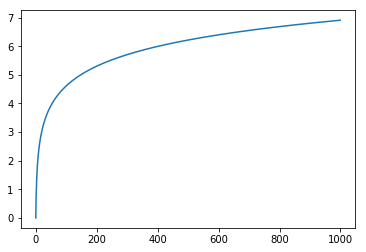

In [17]:
plt.plot([math.log(i) for i in range(1, 1001)])

* Plotting exp:

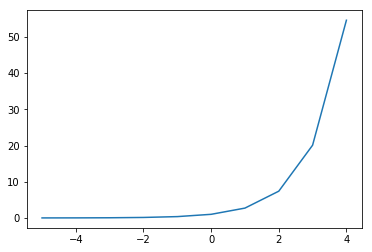

In [27]:
plt.plot(range(-5, 5), [math.exp(i) for i in range(-5, 5)])

## 01:20:25 - Revisit Planets competition

* The planetary dataset has images with multilabel like `haze`, `water` etc.
  * Since we want to predict multithings, softmax isn't so good.
* Good practise to "anthropomorphise your activations functions":
  * Softmax - "I want to pick a single thing"
* Fast.AI knows what to do under the hood with multilabels.
  * It will detect multilabel data and change the underlying activation function.

### 01:25:25 - Data object attributes

* Data object (`ImageClassifierData`) has these attributes:
  * `val_ds` - Validation [Dataset](http://pytorch.org/docs/master/data.html#torch.utils.data.Dataset)
    * Use to get a single image.
  * `val_dl` - Validation [DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader)
    * Use to get a transformed minibatch.
* PyTorch is more Pythonic than Tensorflow, which "reinvents the wheel" a lot.

### 01:41:17 - f2 metric

* f beta function: how much do you weight false negatives vs false positives?
* f2: `f beta with beta = 2`
  * Used because that's what Planets used for the competition.
  * Defined as follows:
    ```
    fbeta_score(targets, predictions, 2, average='samples')
    ```
    
* Fast.ai design philosophy: get everything you probably want by default, but allow you to change it.

### 01:44:24 - Sigmoid (multilabel activation function)

* Similar to softmax, but doesn't divide the values by the sum.
* It should return a number between 0 and 1.
* Allows multiple things to be high.
* On the last layer, it's calculated as `math.exp(activiation) / (1 + math.exp(activation))`.
* Sigmoid math notation: ${\displaystyle S(x)={\frac {1}{1+e^{-x}}}={\frac {e^{x}}{e^{x}+1}}.}$
  * Shape:

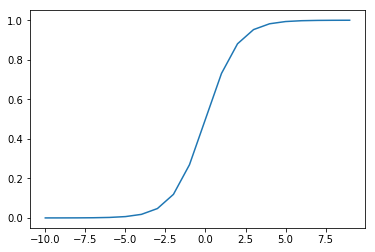

In [32]:
sigmoid = lambda x: math.exp(x) / (1 + math.exp(x))
plt.plot(range(-10, 10), [sigmoid(i) for i in range(-10, 10)])

* used in Logistic Reg.

## 01:47:30 - Audience questions 

* Question 1: why only learn the last layer on the Planet dataset, given how different it is to ImageNet?
* Answer 1: to ensure final layer weights aren't random when training earlier layers - they'll likely take longer to train otherwise.

* Question 2: what is trained when you unfreeze earlier layers - the kernels?
* Answer 2: Training in conv layers is training filters/kernels. Only FC layers have trainable weights.

* Question 3: In example of training satellite images, how do you get an that's 64x64?
* Answer 3: Depends on the transform. When using data augmentation, it takes a randomly choosen crop.

* Question 4: Is the choice of metric different to the loss function?
* Answer 4: Yes - loss function is covered next week. 

* Question 5: Multipass modelling, does the training have to be multiclass?
* Answer 5: Might be possible.

* Question 6: Differential learning rates: are they spread evenly across the layers?
* Answer 6: Yes. It uses layer groups, which were hand picked by Jeremy.
  * Last one always refers to the last layer.
  * Can be overriden in the library.
  
* Question 7: How can you dump the layers of the model?
* Answer 7:

In [8]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math

import matplotlib.pyplot as plt

from fastai.fastai.dataset import ImageClassifierData
from fastai.fastai.conv_learner import ConvLearner
from torchvision.models import resnet34
from fastai.fastai.transforms import tfms_from_model

In [9]:
PATH = 'data/dogscats/'
arch = resnet34
sz = 224
batch_size = 64

In [16]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=batch_size)
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [18]:
# Need to run this first, apparently:
# http://forums.fast.ai/t/understanding-code-error-expected-more-than-1-value-per-channel-when-training/9257/10
learn.predict()

array([[-0.20914, -1.66749],
       [-0.1687 , -1.86279],
       [-0.15854, -1.91996],
       ...,
       [-0.0468 , -3.08508],
       [-0.24362, -1.53149],
       [-0.09405, -2.41057]], dtype=float32)

In [34]:
import pprint

summary = learn.summary()

# Print a sample of it:
print(str(pprint.pformat(summary))[:1000])

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

* Question 8: why was my plot empty when I ran lr_find?
* Answer 8: if you have a tiny dataset, you can't get enough minibatches for lr_find.

## 01:59:47 - Intro to structured data

* Academia mostly ignores structured data, because it's harder to share.
* Couple of new imports:

In [37]:
# Structures data library
from fastai.fastai.structured import *

# Columnar data library
from fastai.fastai.column_data import *

In [38]:
PATH = 'data/rossman/'

* If you're not familiar with Pandas, checkout book called [Python for Data Analysis](https://www.amazon.com/Python-Data-Analysis-Wrangling-IPython/dp/1449319793).

* Download Rossman dataset:

In [40]:
!kaggle competitions download -c rossmann-store-sales --path='{PATH}'

sample_submission.csv.zip: Downloaded 55KB of 55KB
store.csv.zip: Downloaded 8KB of 8KB
test.csv.zip: Downloaded 143KB of 143KB
train.csv.zip: Downloaded 6MB of 6MB


In [42]:
!ls -l {PATH}

total 6008
-rw-rw-r-- 1 lex lex   56579 Apr  1 03:37 sample_submission.csv.zip
-rw-rw-r-- 1 lex lex    8529 Apr  1 03:37 store.csv.zip
-rw-rw-r-- 1 lex lex  146686 Apr  1 03:37 test.csv.zip
-rw-rw-r-- 1 lex lex 5931096 Apr  1 03:37 train.csv.zip


In [45]:
for file in os.listdir(PATH):
    if not file.endswith('zip'):
        continue
        
    !unzip -q -d {PATH} {PATH}{file}

* Also download external datasets provided by Kaggle participants:

In [46]:
!wget http://files.fast.ai/part2/lesson14/rossmann.tgz --directory-prefix={PATH}

--2018-04-01 03:41:50--  http://files.fast.ai/part2/lesson14/rossmann.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7730448 (7.4M) [text/plain]
Saving to: ‘data/rossman/rossmann.tgz’

rossmann.tgz        100%[===================>]   7.37M   294KB/s    in 23s     

2018-04-01 03:42:13 (326 KB/s) - ‘data/rossman/rossmann.tgz’ saved [7730448/7730448]



In [48]:
!tar -zxvf {PATH}rossmann.tgz -C {PATH}

googletrend.csv
sample_submission.csv
state_names.csv
store.csv
store_states.csv
test.csv
train.csv
weather.csv
